<a href="https://colab.research.google.com/github/dnaae/spot_detection_/blob/extract-cell-level-results/not6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install big-fish

In [ ]:
#imports
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the top-level folder in your Google Drive
drive_folder = "/content/drive/MyDrive/"

# List the contents of the drive_folder
contents = os.listdir(drive_folder)

# Print the contents and ask the user to select a folder
print("Contents of your Google Drive:")
for i, item in enumerate(contents):
  print(f"{i + 1}: {item}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: CPTH2
9: 5-AZA
10: DMSO
11: FULV
12: experiment_1_dapi_fov_1.tif
13: experiment_1_smfish_fov_1.tif
14: example_nuc_full.tif
15: example_cell_full.tif


In [ ]:
path_input = "/content/drive/MyDrive/CPTH2/output/"

In [ ]:
#Nucleus channel
path = os.path.join(path_input,"MCF7_AREG_CPTH2_501.tif_C1.tif")
nuc = stack.read_image(path)
nuc_mip = stack.maximum_projection(nuc)
print("smfish channel")
print("\r shape: {0}".format(nuc.shape))
print("\r dtype: {0}".format(nuc.dtype), "\n")

#FISH channel
path = os.path.join(path_input,"MCF7_AREG_CPTH2_501.tif_C2.tif")
rna = stack.read_image(path)
rna_mip = stack.maximum_projection(rna)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

#enhance contrast of the FISH image (rna) and create 2D maximum projection of the contrast-enhanced image
image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

smfish channel
 shape: (15, 512, 512)
 dtype: uint16 

smfish channel
 shape: (15, 512, 512)
 dtype: uint16


In [ ]:
#path_cell_label = os.path.join(path_input, "DMSO_004_cell_label(2).tif")  #aoming
path_cell_label = os.path.join(path_input, "cell_label_trial.tif")
# path_nuc_label = os.path.join(path_input, "DMSO_004_nuc_label.tif") #aoming
path_nuc_label = os.path.join(path_input, "nuc_label_trial.tif")
path_spots = os.path.join(path_input, "output_spots_cell_0.csv")
path_foci = os.path.join(path_input, "output_clusters_cell_0.csv")


# segmented cells
cell_label = stack.read_image(path_cell_label)
print("segmented cells")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype), "\n")

# segmented nuclei
nuc_label = stack.read_image(path_nuc_label)
print("segmented nuclei")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype), "\n")

# detected spots
spots = stack.read_array_from_csv(path_spots, dtype=np.int64)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")

# detected foci
clusters = stack.read_array_from_csv(path_foci, dtype=np.int64)
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))






segmented cells
 shape: (512, 512)
 dtype: int64 

segmented nuclei
 shape: (512, 512)
 dtype: int64 

detected spots
 shape: (1445, 4)
 dtype: int64 

detected clusters
 shape: (109, 5)
 dtype: int64


In [ ]:
#discriminate foci from transcription sites
spots_no_ts, foci, ts = multistack.remove_transcription_site(spots, clusters, nuc_label, ndim=3)
print("detected spots (without transcription sites)")
print("\r shape: {0}".format(spots_no_ts.shape))
print("\r dtype: {0}".format(spots_no_ts.dtype))

detected spots (without transcription sites)
 shape: (1353, 4)
 dtype: int64


In [ ]:
#identify object in cellular compartment
spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
print("detected spots (inside nuclei)")
print("\r shape: {0}".format(spots_in.shape))
print("\r dtype: {0}".format(spots_in.dtype), "\n")
print("detected spots (outside nuclei)")
print("\r shape: {0}".format(spots_out.shape))
print("\r dtype: {0}".format(spots_out.dtype))

detected spots (inside nuclei)
 shape: (530, 4)
 dtype: int64 

detected spots (outside nuclei)
 shape: (915, 4)
 dtype: int64


In [ ]:
fov_results = multistack.extract_cell(
    cell_label=cell_label,
    ndim=3,
    nuc_label=nuc_label,
    rna_coord=spots_no_ts,
    others_coord={"foci": foci, "transcription_site": ts},
    image=image_contrasted,
    others_image={"dapi": nuc_mip, "smfish": rna_mip})
print("number of cells identified: {0}".format(len(fov_results)))

number of cells identified: 1


cell 0
 number of rna 932
 number of foci 41
 number of transcription sites 42


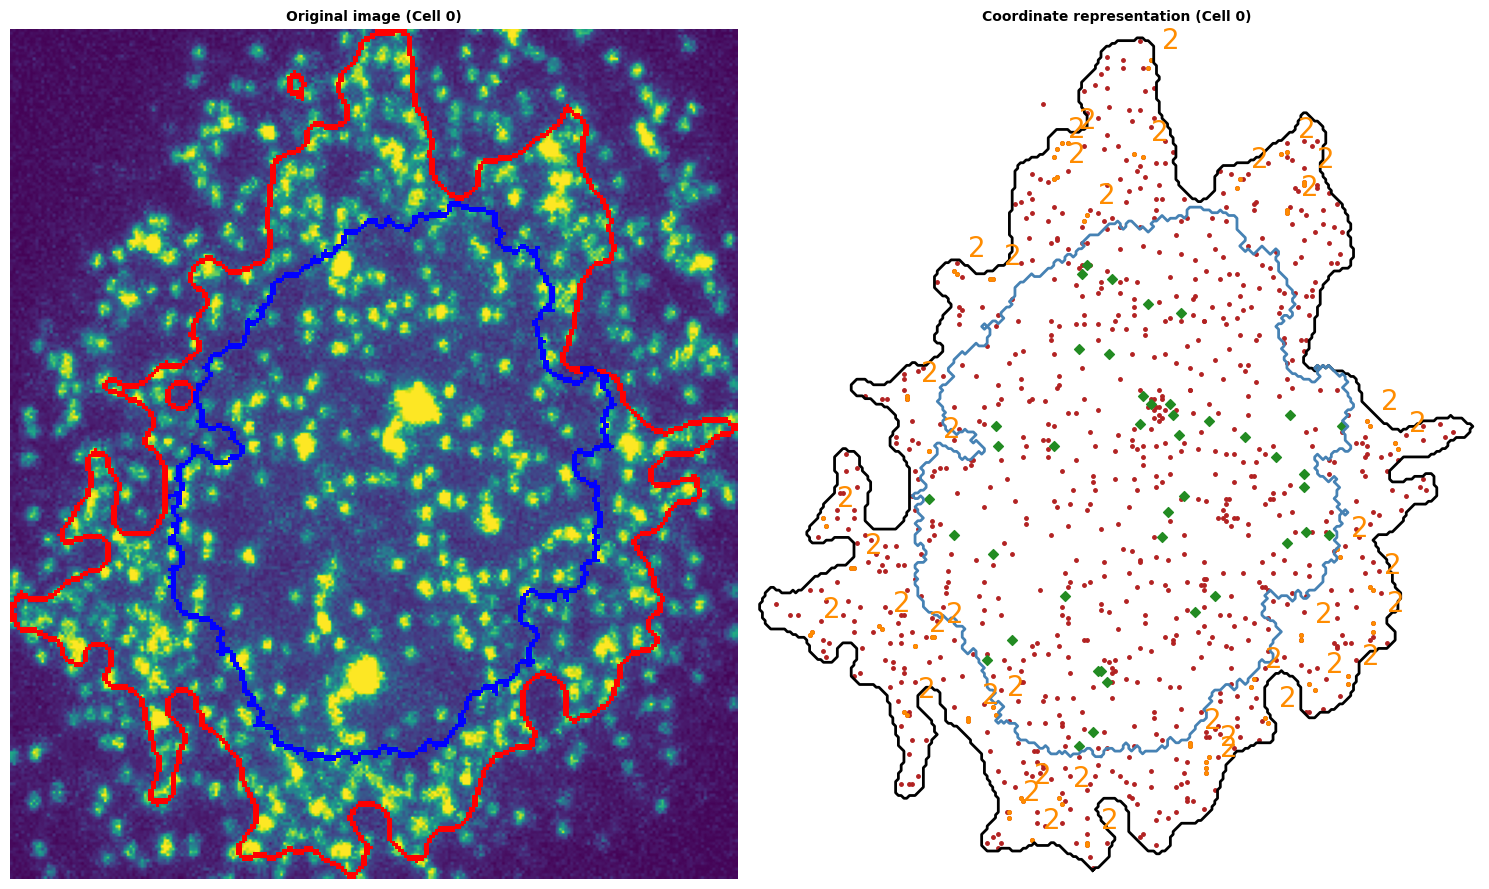

In [ ]:
for i, cell_results in enumerate(fov_results):
    print("cell {0}".format(i))

    # get cell results
    cell_mask = cell_results["cell_mask"]
    cell_coord = cell_results["cell_coord"]
    nuc_mask = cell_results["nuc_mask"]
    nuc_coord = cell_results["nuc_coord"]
    rna_coord = cell_results["rna_coord"]
    foci_coord = cell_results["foci"]
    ts_coord = cell_results["transcription_site"]
    image_contrasted = cell_results["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))
    print("\r number of transcription sites {0}".format(len(ts_coord)))

    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, nuc_coord=nuc_coord,
        rna_coord=rna_coord, foci_coord=foci_coord, other_coord=ts_coord,
        image=image_contrasted, cell_mask=cell_mask, nuc_mask=nuc_mask,
        title="Cell {0}".format(i))




In [ ]:
df = multistack.summarize_extraction_results(fov_results, ndim=3)
print("shape: {0}".format(df.shape))
df.head()

shape: (1, 8)


,cell_id,cell_area,nuc_area,nb_rna,nb_rna_in_nuc,nb_rna_out_nuc,nb_foci,nb_transcription_site
0,1,38709,21574,932,439,493,41,42


In [ ]:
for i, cell_results in enumerate(fov_results):
    # save results
    path = os.path.join(path_input, "results_cell_{0}.npz".format(i))
    stack.save_cell_extracted(cell_results, path)

In [ ]:
# read results for the first cell of the FoV
path = os.path.join(path_input, "results_cell_0.npz")
cell_results = stack.read_cell_extracted(path, verbose=True)
print(cell_results["rna_coord"])

Available keys: cell_id, bbox, cell_coord, cell_mask, nuc_coord, nuc_mask, rna_coord, foci, transcription_site, image, dapi, smfish 

[[  0  95 168  -1]
 [  0  96 162  -1]
 [  0 101 159  -1]
 ...
 [ 14 220 182  -1]
 [ 14 245 180  -1]
 [ 14 256  99  -1]]
